## Notebook for exploratory analysis of Fetal Gut Stem cells scRNA-Seq data using `scVI` and `SCCAF-leiden`

- **Developed by:** Anna Maguza
- **Affilation:** Faculty of Medicine, Würzburg University
- **Date of creation:** 6th November 2023
- **Last modified date:** 3rd September 2024

This notebook is created to identify populations in fetal stem cells data from Elementaite, 2021 datase. Firstly, we will correct batch using `scvi`and then identify clusters using `leiden` and `SCCAF`. 

### Load required modules

In [19]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt

In [3]:
torch.cuda.is_available()

True

In [5]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.3
scanpy      1.9.6
-----
PIL                         10.1.0
absl                        NA
aiohttp                     3.8.6
aiosignal                   1.3.1
annotated_types             0.6.0
anyio                       NA
arrow                       1.3.0
asttokens                   NA
async_timeout               4.0.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backoff                     2.2.1
brotli                      1.1.0
bs4                         4.12.2
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          3.3.2
chex                        0.1.7
click                       8.1.7
colorama                    0.4.6
comm                        0.1.4
contextlib2                 NA
croniter                    NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.8.0
decor

In [6]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Read in datasets

- Read in formatted object

In [7]:
adata = sc.read_h5ad('data/Fetal_stem_cells.h5ad')
adata

AnnData object with n_obs × n_vars = 7817 × 26442
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0'

- Perform basic filtering 

In [45]:
sc.pp.filter_genes(adata, min_counts = 1)
sc.pp.filter_genes(adata, min_cells = 3)

sc.pp.filter_cells(adata, min_genes = 50)
sc.pp.filter_cells(adata, min_counts = 3)

filtered out 4120 genes that are detected in less than 1 counts
filtered out 2454 genes that are detected in less than 3 cells


- Check if the object is raw

In [9]:
X_is_raw(adata)

True

- Save raw counts to anndata

In [10]:
adata_raw_copy = adata.copy()

### Calculate HVGs

In [11]:
adata.layers['counts'] = adata.X.copy()

In [12]:
sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "Fraction",
    subset = True,
    span = 1
)
adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 7817 × 7000
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    layers: 'counts'

### Data integration with `scVI`

- Create a model

In [13]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer = "counts",
    categorical_covariate_keys = ["Fraction"],
    continuous_covariate_keys = ["n_genes", "n_counts"]
)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [15]:
scvi_model = scvi.model.SCVI(adata, n_layers = 3, n_latent = 50, gene_likelihood = "nb", dispersion = 'gene-batch')
scvi_model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 50, n_layers: 3, dropout_rate: 0.1, dispersion: gene-batch, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Not Trained
Model's adata is minified?: False

- Train a model

In [16]:
scvi_model.train(400, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True, 
                 accelerator = "gpu",
                 devices = [0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 400/400: 100%|█| 400/400 [02:27<00:00,  2.77it/s, v_num=1, train_loss_step=3.13e+3, train_loss_epoch

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [02:27<00:00,  2.71it/s, v_num=1, train_loss_step=3.13e+3, train_loss_epoch


In [17]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation(adata)

#### Evaluate model performance using the [_Svensson_](https://www.nxn.se/valent/2023/8/10/training-scvi-posterior-predictive-distributions-over-epochs) method

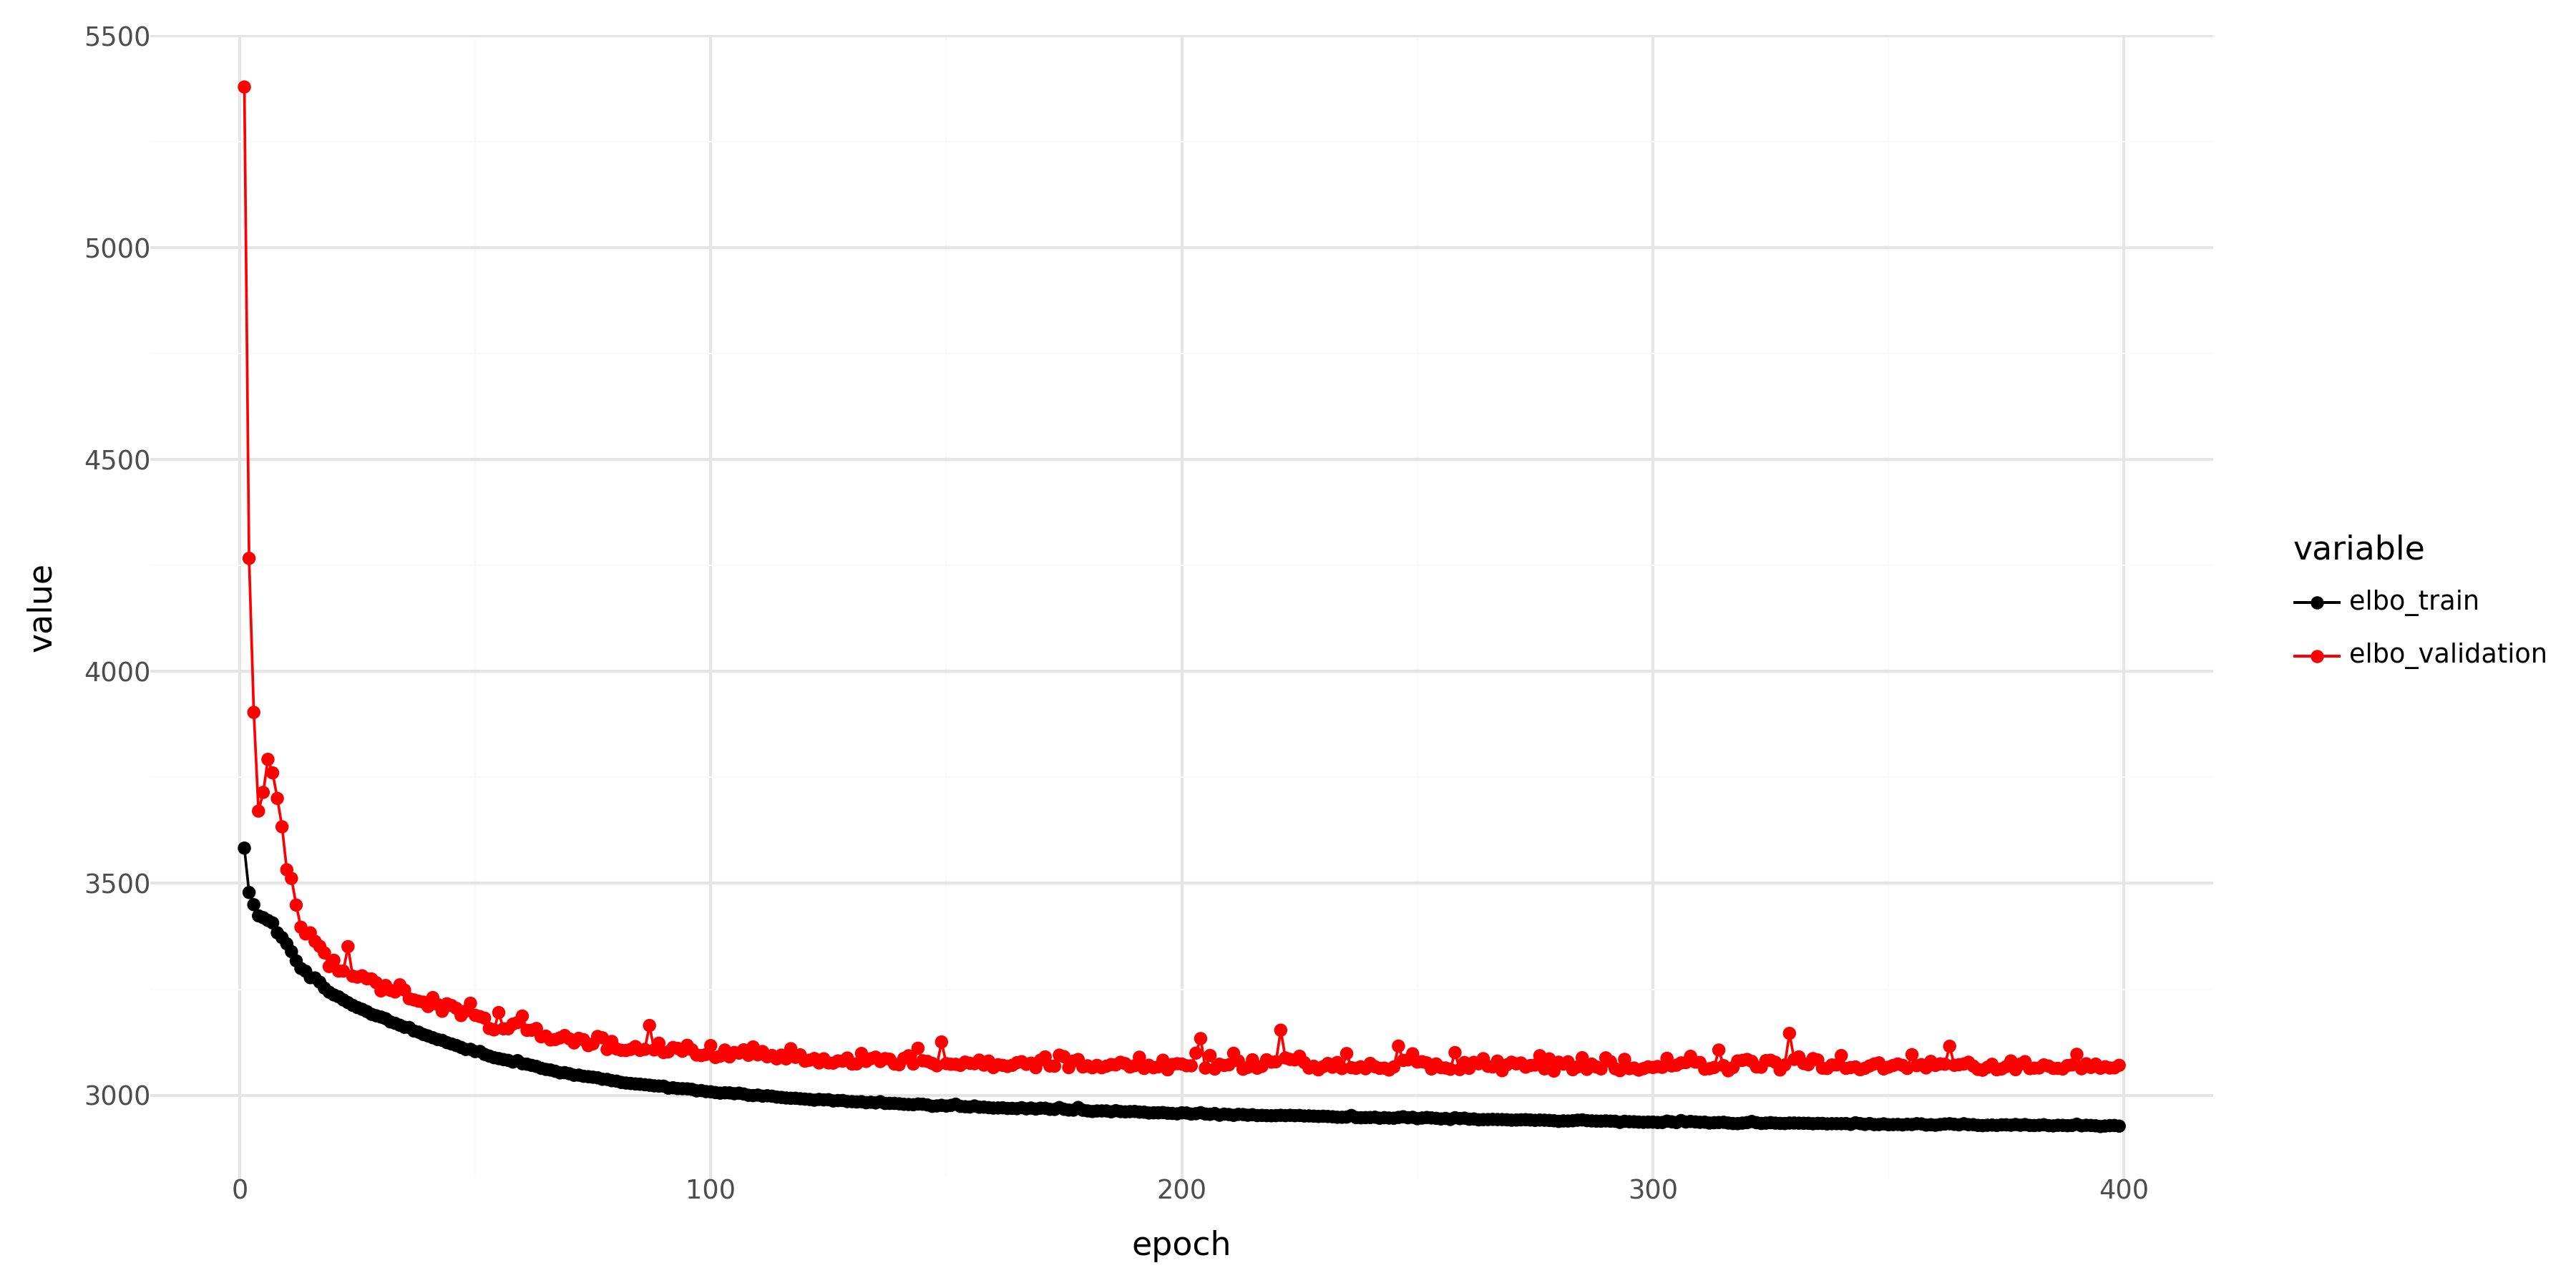

In [20]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

print(p_)

- Calculate UMAP

In [21]:
sc.pp.neighbors(adata, use_rep = "X_scVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 1, random_state = 1712)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


In [29]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 7817 × 7000
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0', 'n_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'neighbors', 'umap', 'Library_Preparation_Protocol_colors', 'Fraction_colors', 'Donor_ID_colors', 'Cell Type_colors', 'Age_colors'
    obsm: '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs', 'X_scV

In [ ]:
sc.set_figure_params(dpi = 300, figsize=(10,7))
sc.pl.umap(adata, color = ['Cell Type', 'Cell States', 'Fraction', 'Cell States GCA', 'Age', 'Library_Preparation_Protocol', 'Donor_ID', 'n_genes', 'n_counts', 'pct_counts_mito', 'pct_counts_ribo'], ncols = 4, frameon = False, size = 10)

+ Save anndata object

In [39]:
write_adata = anndata.AnnData(X=adata_raw_copy.X,
                                obs=adata.obs,
                                var=adata_raw_copy.var,
                                obsm=adata.obsm,
                                uns=adata.uns,
                                obsp= adata.obsp)

In [47]:
write_adata.write_h5ad('data/Fetal_stem_cells_scvi.h5ad')

### Cluster manifold using `leiden` + `SCCAF`

In [1]:
import SCCAF
from SCCAF import SCCAF_assessment, plot_roc

In [2]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

- Upload dataset

In [7]:
# data upload
input = 'FetalSC_data/Fetal_healthy_stem_cells_scvi.h5ad'
adata = sc.read_h5ad(input)

- Extract raw counts

In [8]:
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 7817 × 19868
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0', 'n_counts', 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    obsp: 'connectivities', 'distances'

- Save raw counts

In [9]:
adata.raw = adata

- Normalize and log transform data

In [6]:
sc.pp.normalize_total(adata, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata)

- Perform leiden clustering with resolution 0.1 and assess with SCCAF

In [ ]:
sc.tl.leiden(adata, resolution = 0.1, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)
plt.show()

- Perform leiden clustering with resolution 0.2 and assess with SCCAF (chosen resolution)

In [ ]:
# Chosen resolution
sc.tl.leiden(adata, resolution = 0.2, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)
plt.show()

- Perform leiden clustering with resolution 0.3 and assess with SCCAF

In [ ]:

sc.tl.leiden(adata, resolution = 0.3, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)
plt.show()

- Perform leiden clustering with resolution 0.4 and assess with SCCAF

In [ ]:
sc.tl.leiden(adata, resolution = 0.4, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)
plt.show()

- Perform leiden clustering with resolution 0.5 and assess with SCCAF

In [ ]:
sc.tl.leiden(adata, resolution = 0.5, random_state = 1786)
y_prob, y_pred, y_test, clf, cvsm, acc = SCCAF_assessment(adata.X, adata.obs['leiden'], n = 100)
plot_roc(y_prob, y_test, clf, cvsm = cvsm, acc = acc)
plt.show()

In [ ]:
sc.tl.leiden(adata, resolution = 0.2, random_state = 1786)

In [14]:
adata.write_h5ad('FetalSC_data/Fetal_healthy_stem_cells_leiden.h5ad')

In [ ]:
adata = sc.read_h5ad('FetalSC_data/Fetal_healthy_stem_cells_leiden.h5ad')

### Clusters manual annotation

In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import numpy as np
import pandas as pd
import scanpy as sc


from umap import UMAP
import warnings; warnings.simplefilter('ignore')

- Upload dataset

In [10]:
input = 'FetalSC_data/Fetal_healthy_stem_cells_leiden.h5ad'
adata = sc.read_h5ad(input)

- Extract raw counts

In [ ]:
adata = adata.raw.to_adata()
adata

- Normalize and log transform data

In [4]:
adata_log = adata.copy()
sc.pp.normalize_total(adata_log, target_sum = 1e6, exclude_highly_expressed = True)
sc.pp.log1p(adata_log)

- Visualize UMAP

In [ ]:
sc.set_figure_params(dpi=300)
sc.pl.umap(adata_log, frameon = False, color = ['leiden', 'Donor_ID', 'Age', 'Age_group', 'Library_Preparation_Protocol', 'Sex', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ribo'], size = 8, legend_fontsize = 5, ncols = 3, color_map='magma')

- Calculate differentially expressed genes

In [15]:
sc.tl.rank_genes_groups(adata_log, groupby="leiden", method='wilcoxon', n_genes=100)
df = sc.get.rank_genes_groups_df(adata_log, group=None)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


- Save differentially expressed genes

In [16]:
df.to_csv('FetalSC_data/FetalSC_wilcoxon_gene_ranks.csv')

In [19]:
df.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,MTRNR2L12,48.794552,6.386019,0.000000e+00,0.000000e+00
1,0,ASS1,38.726536,3.609820,0.000000e+00,0.000000e+00
2,0,KRT18,37.872299,2.212804,0.000000e+00,0.000000e+00
3,0,CCL25,35.024929,3.639875,9.392482e-269,1.866098e-265
4,0,RPS4X,34.138531,0.464431,1.978860e-255,3.574182e-252


- Plot top 24 differentially expressed genes for cluster 0

In [38]:
# Filter for cluster 0 and sort by scores
top_genes_cluster_0 = df[df['group'] == '0'].sort_values(by='scores', ascending=False).head(24)

In [ ]:
# Define the number of rows and columns for the subplot grid
n_rows = 5
n_cols = 5

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plot UMAP for 'leiden' in the first subplot
sc.pl.umap(adata_log, color='leiden', ax=axs[0], show=False, title='Leiden', frameon=False)

# Plot UMAP for each top gene in the subsequent subplots
for idx, gene in enumerate(top_genes_cluster_0['names']):
    sc.pl.umap(adata_log, color=gene, ax=axs[idx + 1], show=False, title=gene, frameon=False)

# Hide any unused subplots
for ax in axs[len(top_genes_cluster_0) + 1:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

- Plot top 24 differentially expressed genes for cluster 1

In [40]:
# Filter for cluster 0 and sort by scores
top_genes_cluster_1 = df[df['group'] == '1'].sort_values(by='scores', ascending=False).head(24)

In [ ]:
# Define the number of rows and columns for the subplot grid
n_rows = 5
n_cols = 5

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plot UMAP for 'leiden' in the first subplot
sc.pl.umap(adata_log, color='leiden', ax=axs[0], show=False, title='Leiden', frameon=False)

# Plot UMAP for each top gene in the subsequent subplots
for idx, gene in enumerate(top_genes_cluster_1['names']):
    sc.pl.umap(adata_log, color=gene, ax=axs[idx + 1], show=False, title=gene, frameon=False)

# Hide any unused subplots
for ax in axs[len(top_genes_cluster_1) + 1:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

- Plot top 24 differentially expressed genes for cluster 1

In [42]:
# Filter for cluster 2 and sort by scores
top_genes_cluster_2 = df[df['group'] == '2'].sort_values(by='scores', ascending=False).head(24)

In [ ]:
# Define the number of rows and columns for the subplot grid
n_rows = 5
n_cols = 5

# Create a figure with subplots
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

# Flatten the array of axes for easy iteration
axs = axs.flatten()

# Plot UMAP for 'leiden' in the first subplot
sc.pl.umap(adata_log, color='leiden', ax=axs[0], show=False, title='Leiden', frameon=False)

# Plot UMAP for each top gene in the subsequent subplots
for idx, gene in enumerate(top_genes_cluster_2['names']):
    sc.pl.umap(adata_log, color=gene, ax=axs[idx + 1], show=False, title=gene, frameon=False)

# Hide any unused subplots
for ax in axs[len(top_genes_cluster_2) + 1:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()

- Visualise top differently expressed genes on the dotplot

In [49]:
# Create a list with top differently expressed genes
top_genes_cluster_0 = df[df['group'] == '0'].sort_values(by='scores', ascending=False).head(20)
top_genes_cluster_0 = top_genes_cluster_0['names'].tolist()
top_genes_cluster_1 = df[df['group'] == '1'].sort_values(by='scores', ascending=False).head(20)
top_genes_cluster_1 = top_genes_cluster_1['names'].tolist()
top_genes_cluster_2 = df[df['group'] == '2'].sort_values(by='scores', ascending=False).head(20)
top_genes_cluster_2 = top_genes_cluster_2['names'].tolist()
top_diff_expressed_genes = top_genes_cluster_0+top_genes_cluster_1+top_genes_cluster_2

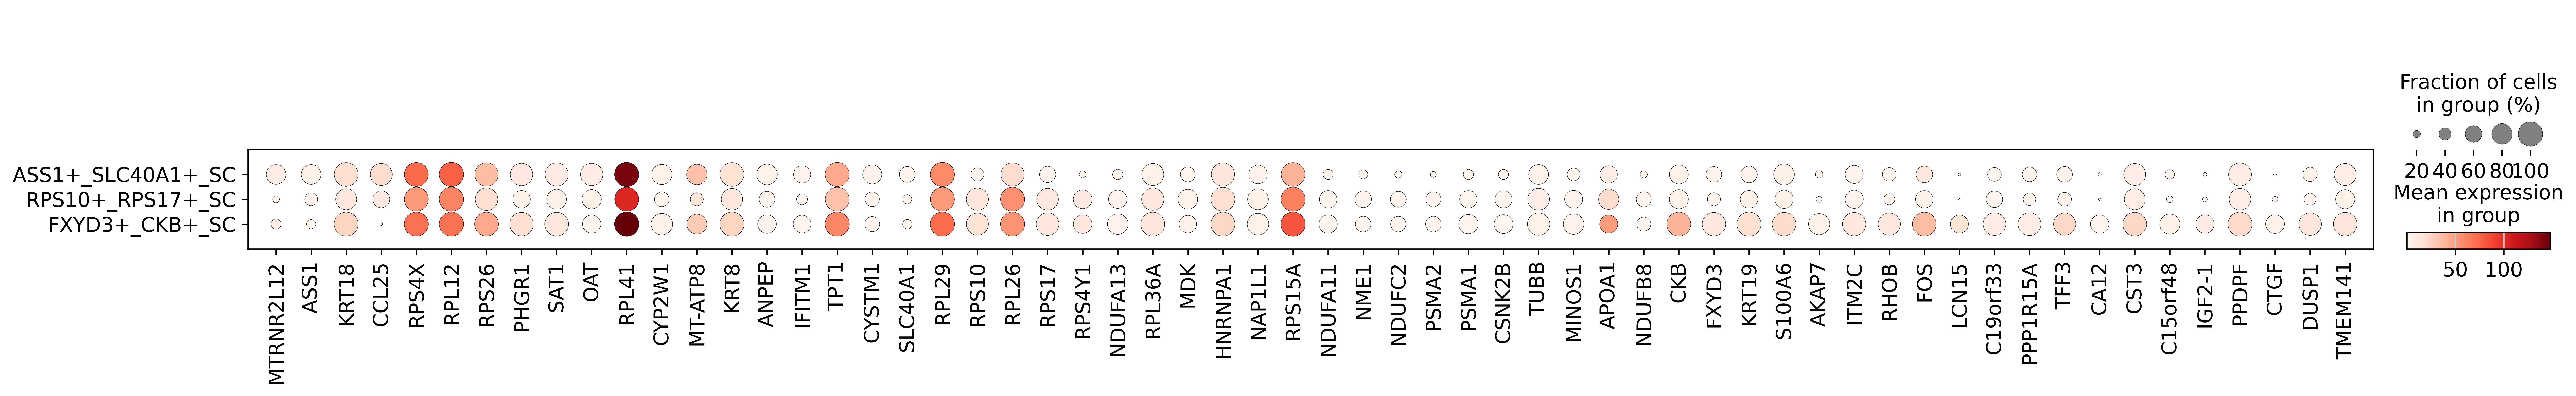

In [50]:
sc.pl.dotplot(adata, top_diff_expressed_genes, groupby='cluster')

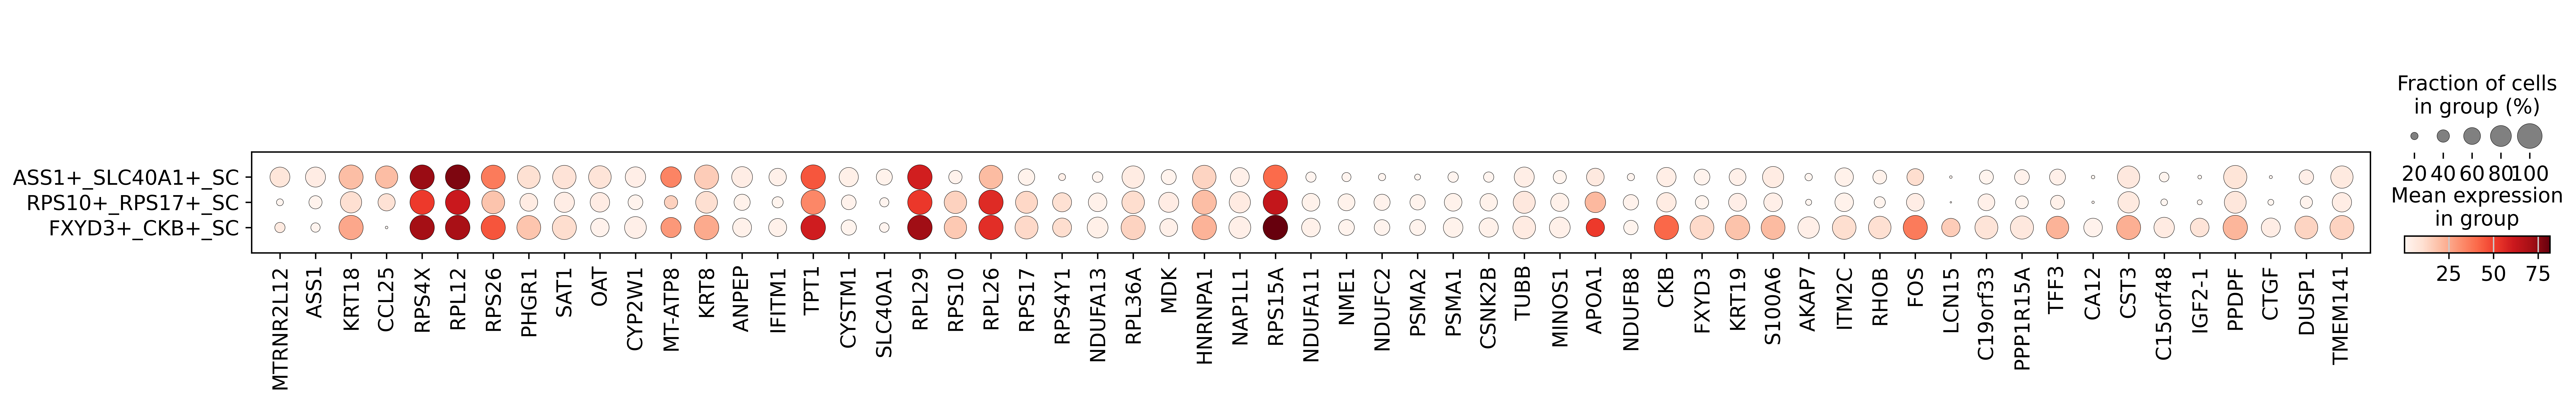

In [51]:
# Exclude 'RPL41' from top_diff_expressed_genes
top_diff_expressed_genes = [x for x in top_diff_expressed_genes if x != 'RPL41']
sc.pl.dotplot(adata, top_diff_expressed_genes, groupby='cluster')

In [54]:
# Copy leiden column to cluster column
adata.obs['cluster'] = adata.obs['leiden']

In [55]:
adata.obs['cluster'] = adata.obs['cluster'].replace(['0','1','2'],['MTRNR2L12+ASS1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'])

In [56]:
adata.obs['cluster'].value_counts()

cluster
MTRNR2L12+ASS1+_SC    3979
RPS10+_RPS17+_SC      3544
FXYD3+_CKB+_SC         294
Name: count, dtype: int64

In [57]:
adata.write_h5ad('FetalSC_data/Fetal_healthy_stem_cells_leiden.h5ad')

+ Create UMAP plot with custom color pallete

In [12]:
input = 'FetalSC_data/Fetal_healthy_stem_cells_leiden.h5ad'
adata = sc.read_h5ad(input)

In [13]:
adata

AnnData object with n_obs × n_vars = 7817 × 19868
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels', 'n_genes', 'n_counts', 'leiden', 'cluster'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0', 'n_counts', 'n_cells'
    uns: 'Age_colors', 'Age_group_colors', 'Donor_ID_colors', 'Library_Preparation_Protocol_colors', 'Sex_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    obsp: 'connectivities', 'distances'

In [ ]:
new_palette = ['#A3D8FF', '#E9A8F2', '#97BE5A']  

# Assign the new color palette to your categories
adata.uns['cluster_colors'] = new_palette

fig_dir = '/mnt/LaCIE/annaM/gut_project/Processed_data/Gut_data/Plots/Finding_stem_cells'

with plt.rc_context():
    sc.set_figure_params(dpi=300, figsize=(10, 10))
    sc.pl.umap(adata, frameon=False, color='cluster', size=100, legend_fontsize=5, ncols=3, show=False)
    plt.savefig(f"{fig_dir}/fetal_stem_cells_umap.png", bbox_inches="tight")